In [90]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    LinearRegression, 
    PoissonRegressor, 
    GammaRegressor, 
    TweedieRegressor, 
    LogisticRegression
)
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score,
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    roc_auc_score, 
    classification_report
)
from sklearn.utils.validation import check_is_fitted
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import RFECV
from sklearn.linear_model import ElasticNet, LogisticRegression

In [95]:
# test data 

np.random.seed(100)
n_samples = 8000

# numeric
age = np.random.randint(18, 70, n_samples)
income = np.random.normal(50000, 15000, n_samples)
num_transactions = np.random.poisson(10, n_samples)

# categorical
gender = np.random.choice(['Male', 'Female'], n_samples)
region = np.random.choice(['North', 'South', 'East', 'West'], n_samples)
product_type = np.random.choice(['A', 'B', 'C'], n_samples)

# continuous target
target_continuous = 0.05 * age + 0.0005 * income + 0.3 * num_transactions + np.random.normal(0, 2, n_samples)

# binary classification target
target_binary = (target_continuous > np.median(target_continuous)).astype(int)


df = pd.DataFrame({
    'age': age,
    'income': income,
    'num_transactions': num_transactions,
    'gender': gender,
    'region': region,
    'product_type': product_type,
    'target': target_continuous  # switch to target_binary for classification 
})

In [96]:
# Load Data

#df = pd.read_csv("data.csv")

X = df.drop("target", axis=1)
y = df["target"]

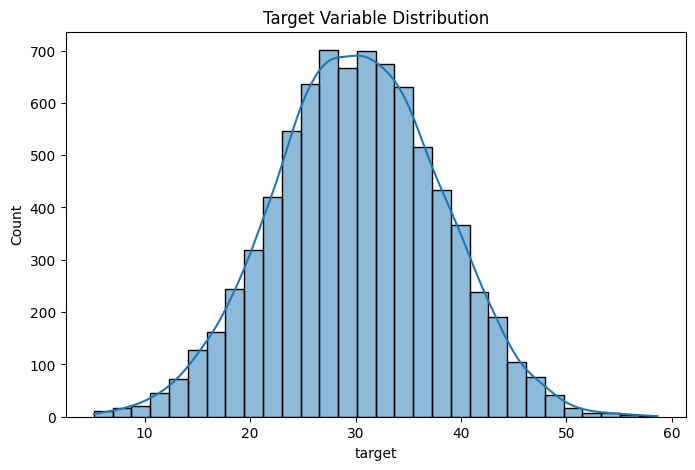

Skewness: -0.0066
Kurtosis: -0.0949


In [97]:
# Distribution

plt.figure(figsize=(8, 5))
sns.histplot(y, kde=True, bins=30)
plt.title("Target Variable Distribution")
plt.show()

print("Skewness:", round(y.skew(),4))
print("Kurtosis:", round(y.kurt(), 4))

In [98]:
# Train/Test Split

try:
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError:
    # if y is continuous
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )


In [ ]:
# Preprocessing

numeric_features = ['age', 'income', 'num_transactions']
categorical_features = ['gender', 'region', 'product_type']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [100]:
# Parameter Grids

models = {
    "LinearRegression": (LinearRegression(), {
        # no hyperparameters to tune for LinearRegression
    }),
    "PoissonRegressor": (PoissonRegressor(max_iter=1000), {
        "clf__alpha": [0.001, 0.01, 0.1, 1.0],
    }),
    "GammaRegressor": (GammaRegressor(max_iter=1000), {
        "clf__alpha": [0.001, 0.01, 0.1, 1.0],
    }),
    "TweedieRegressor": (TweedieRegressor(max_iter=1000), {
        "clf__power": [0, 1, 1.5, 1.8, 2],
        "clf__alpha": [0.001, 0.01, 0.1, 1.0],
    }),
    "LogisticRegression": (LogisticRegression(
        solver="saga", penalty="elasticnet", max_iter=2000, random_state=1
    ), {
        "clf__C": np.logspace(-4, 2, 10),
        "clf__l1_ratio": [0, 0.25, 0.5, 0.75, 1.0]
    })
}

# Cross Validation

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if len(y.unique()) < 10 else KFold(n_splits=5, shuffle=True, random_state=1)

In [101]:
# Training

def train_models(X_train, y_train, X_test, y_test, selection_method=None):

    results = []
    fitted_pipelines = []

    for name, (model, params) in models.items():
        print(f"\n🔹 Training {name}...")

        # Skip Poisson/Gamma/Tweedie if target has non-positive values
        if isinstance(model, (PoissonRegressor, GammaRegressor, TweedieRegressor)) and (y_train <= 0).any():
            print(f"⚠️ Skipping {name} due to non-positive target values")
            continue

        pipe = Pipeline([("prep", preprocessor), ("clf", model)])

        if selection_method == 'elasticnet':
            if "Logistic" in name:
                sel_model = LogisticRegression(
                    solver="saga", penalty="elasticnet", l1_ratio=0.5, C=1.0, max_iter=2000
                )
            else:
                sel_model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=2000)

            pipe = Pipeline([("prep", preprocessor), ("selector", sel_model), ("clf", model)])
            print("💡 Using ElasticNet for feature selection")

        elif selection_method == 'rfecv':

            if "Logistic" in name:
                estimator = LogisticRegression(solver="liblinear", max_iter=2000)
            else:
                estimator = LinearRegression()
            rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='r2' if "Logistic" not in name else 'roc_auc')
            pipe = Pipeline([("prep", preprocessor), ("selector", rfecv), ("clf", model)])
            print("💡 Using RFECV for feature selection")

        scoring = "roc_auc" if "Logistic" in name else "r2"

        grid = GridSearchCV(pipe, param_grid=params, cv=cv, n_jobs=-1, scoring=scoring, return_train_score=False)

        try:
            y_train_use = y_train if "Logistic" not in name else (y_train > np.median(y_train)).astype(int)
            y_test_use = y_test if "Logistic" not in name else (y_test > np.median(y_test)).astype(int)

            grid.fit(X_train, y_train_use)
            best_model = grid.best_estimator_
            fitted_pipelines.append(best_model)
            y_pred = best_model.predict(X_test)

            if "Logistic" in name:
                y_pred_binary = (y_pred > 0.5).astype(int)
                metrics = {
                    "Model": name,
                    "Best Params": grid.best_params_,
                    "Accuracy": accuracy_score(y_test_use, y_pred_binary),
                    "Recall": recall_score(y_test_use, y_pred_binary),
                    "Precision": precision_score(y_test_use, y_pred_binary),
                    "F1 Score": f1_score(y_test_use, y_pred_binary),
                    "RMSE": np.sqrt(mean_squared_error(y_test_use, y_pred)),
                    "MAE": mean_absolute_error(y_test_use, y_pred),
                    "R² Score": r2_score(y_test_use, y_pred),
                }
            else:
                n = len(y_test_use)
                p = X_train.shape[1]
                rss = np.sum((y_test_use - y_pred) ** 2)
                mse = mean_squared_error(y_test_use, y_pred)
                aic = n * np.log(rss / n) + 2 * p
                bic = n * np.log(rss / n) + p * np.log(n)
                metrics = {
                    "Model": name,
                    "Best Params": grid.best_params_,
                    "RMSE": np.sqrt(mse),
                    "MAE": mean_absolute_error(y_test_use, y_pred),
                    "R² Score": r2_score(y_test_use, y_pred),
                    "AIC": aic,
                    "BIC": bic
                }

            results.append(metrics)
        except Exception as e:
            print(f"⚠️ Skipping {name} due to error: {e}")
            continue

    return results, fitted_pipelines

In [102]:
# No feature selection
# results, pipelines = train_models(X_train_full, y_train_full, X_test, y_test, selection_method=None)

# ElasticNet → unimportant features get near-zero weights.
#results, pipelines = train_models(X_train_full, y_train_full, X_test, y_test, selection_method='elasticnet')

# RFECV → removes features that do not improve cross-validated performance.
results, pipelines = train_models(X_train_full, y_train_full, X_test, y_test, selection_method='rfecv')



🔹 Training LinearRegression...
💡 Using RFECV for feature selection

🔹 Training PoissonRegressor...
💡 Using RFECV for feature selection

🔹 Training GammaRegressor...
💡 Using RFECV for feature selection

🔹 Training TweedieRegressor...
💡 Using RFECV for feature selection

🔹 Training LogisticRegression...
💡 Using RFECV for feature selection


In [103]:
# Results Summary

results_df = pd.DataFrame(results)
print("\n✅ Model Evaluation Summary:")
results_df



✅ Model Evaluation Summary:


,Model,Best Params,RMSE,MAE,R² Score,AIC,BIC,Accuracy,Recall,Precision,F1 Score
0,LinearRegression,{},1.975077,1.562689,0.938627,2189.943971,2222.210524,NaN,NaN,NaN,NaN
1,PoissonRegressor,{'clf__alpha': 1.0},2.370777,1.801190,0.911572,2774.297408,2806.563961,NaN,NaN,NaN,NaN
2,GammaRegressor,{'clf__alpha': 0.1},2.370971,1.809721,0.911558,2774.558227,2806.824780,NaN,NaN,NaN,NaN
3,TweedieRegressor,"{'clf__alpha': 0.001, 'clf__power': 0}",1.975377,1.562991,0.938609,2190.430124,2222.696678,NaN,NaN,NaN,NaN
4,LogisticRegression,"{'clf__C': 1.0, 'clf__l1_ratio': 0.5}",0.279508,0.078125,0.687500,NaN,NaN,0.921875,0.9525,0.897527,0.924196


In [104]:
# Best Regression Model by R²
regression_results = [r for r in results if 'R² Score' in r]
best_model_name = max(regression_results, key=lambda x: x['R² Score'])['Model']
best_model_index = [i for i, r in enumerate(results) if r['Model']==best_model_name][0]
best_model_pipeline = pipelines[best_model_index]

In [105]:
print(f"\n🏆 Best Regression Model: {best_model_name}")


🏆 Best Regression Model: LinearRegression


In [110]:
for pipe in pipelines:
    print("\nModel:", pipe.named_steps["clf"].__class__.__name__)

    if hasattr(pipe.named_steps["clf"], "coef_"):
        coef = pipe.named_steps["clf"].coef_
    elif hasattr(pipe.named_steps["clf"], "feature_importances_"):
        coef = pipe.named_steps["clf"].feature_importances_
    else:
        print("❌ Model has no coefficients")
        continue

    if coef.ndim > 1:
        coef = coef.flatten()

    intercept = pipe.named_steps["clf"].intercept_
    if hasattr(intercept, "__len__"):  
        intercept = float(intercept.ravel()[0]) 

    prep = pipe.named_steps["prep"]
    feature_names = prep.get_feature_names_out()

    if "selector" in pipe.named_steps:
        selector = pipe.named_steps["selector"]

        if hasattr(selector, "get_support"):
            mask = selector.get_support()
            feature_names = feature_names[mask]
            print("🔎 Feature selection applied.")

    df_coef = pd.DataFrame({
        "feature": feature_names,
        "coef": coef
    })

    df_intercept = pd.DataFrame({
        "feature": ["Intercept"],
        "coef": [intercept]
    })

    df_coef = pd.concat([df_intercept, df_coef], ignore_index=True)

    print(df_coef)



Model: LinearRegression
🔎 Feature selection applied.
                 feature       coef
0              Intercept  30.061319
1               num__age   0.711112
2            num__income   7.438568
3  num__num_transactions   0.945883

Model: PoissonRegressor
🔎 Feature selection applied.
                 feature      coef
0              Intercept  3.373704
1               num__age  0.023350
2            num__income  0.239634
3  num__num_transactions  0.030491

Model: GammaRegressor
🔎 Feature selection applied.
                 feature      coef
0              Intercept  3.369854
1               num__age  0.023596
2            num__income  0.238748
3  num__num_transactions  0.031140

Model: TweedieRegressor
🔎 Feature selection applied.
                 feature       coef
0              Intercept  30.061319
1               num__age   0.710577
2            num__income   7.431143
3  num__num_transactions   0.944926

Model: LogisticRegression
🔎 Feature selection applied.
                 fea

In [111]:
def regression_diagnostics(model, X, y, name="Model"):
    # Use transformed X if it's a pipeline with preprocessing
    try:
        X_transformed = model.named_steps['prep'].transform(X)
    except:
        X_transformed = X

    # Predictions and residuals
    y_pred = model.predict(X)
    residuals = y - y_pred
    fitted = y_pred

    # 1️⃣ Residuals vs Fitted
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2,2,1)
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"{name} - Residuals vs Fitted")
    
    # 2️⃣ Normal Q-Q
    plt.subplot(2,2,2)
    qqplot(residuals, line='45', fit=True, ax=plt.gca())
    plt.title(f"{name} - Normal Q-Q")
    
    # 3️⃣ Scale-Location
    plt.subplot(2,2,3)
    sns.scatterplot(x=fitted, y=np.sqrt(np.abs(residuals)))
    plt.xlabel("Fitted values")
    plt.ylabel("Sqrt(|Residuals|)")
    plt.title(f"{name} - Scale-Location")
    
    # 4️⃣ Residuals vs Leverage
    plt.subplot(2,2,4)
    X_with_const = sm.add_constant(X_transformed)
    ols_model = sm.OLS(y, X_with_const).fit()
    influence = OLSInfluence(ols_model)
    leverage = influence.hat_matrix_diag
    standardized_residuals = influence.resid_studentized_internal
    sns.scatterplot(x=leverage, y=standardized_residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Leverage")
    plt.ylabel("Standardized Residuals")
    plt.title(f"{name} - Residuals vs Leverage")
    
    plt.tight_layout()
    plt.show()

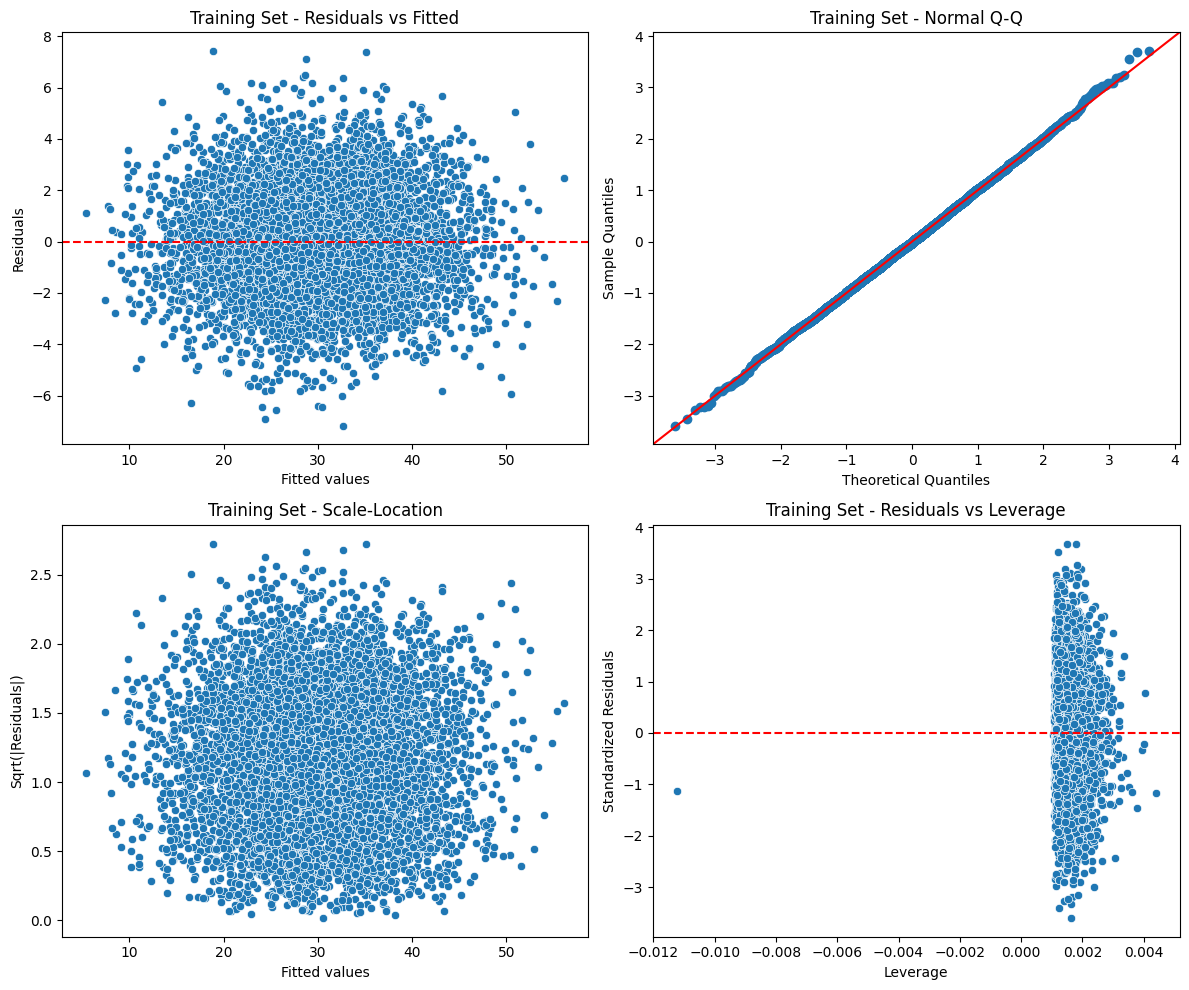

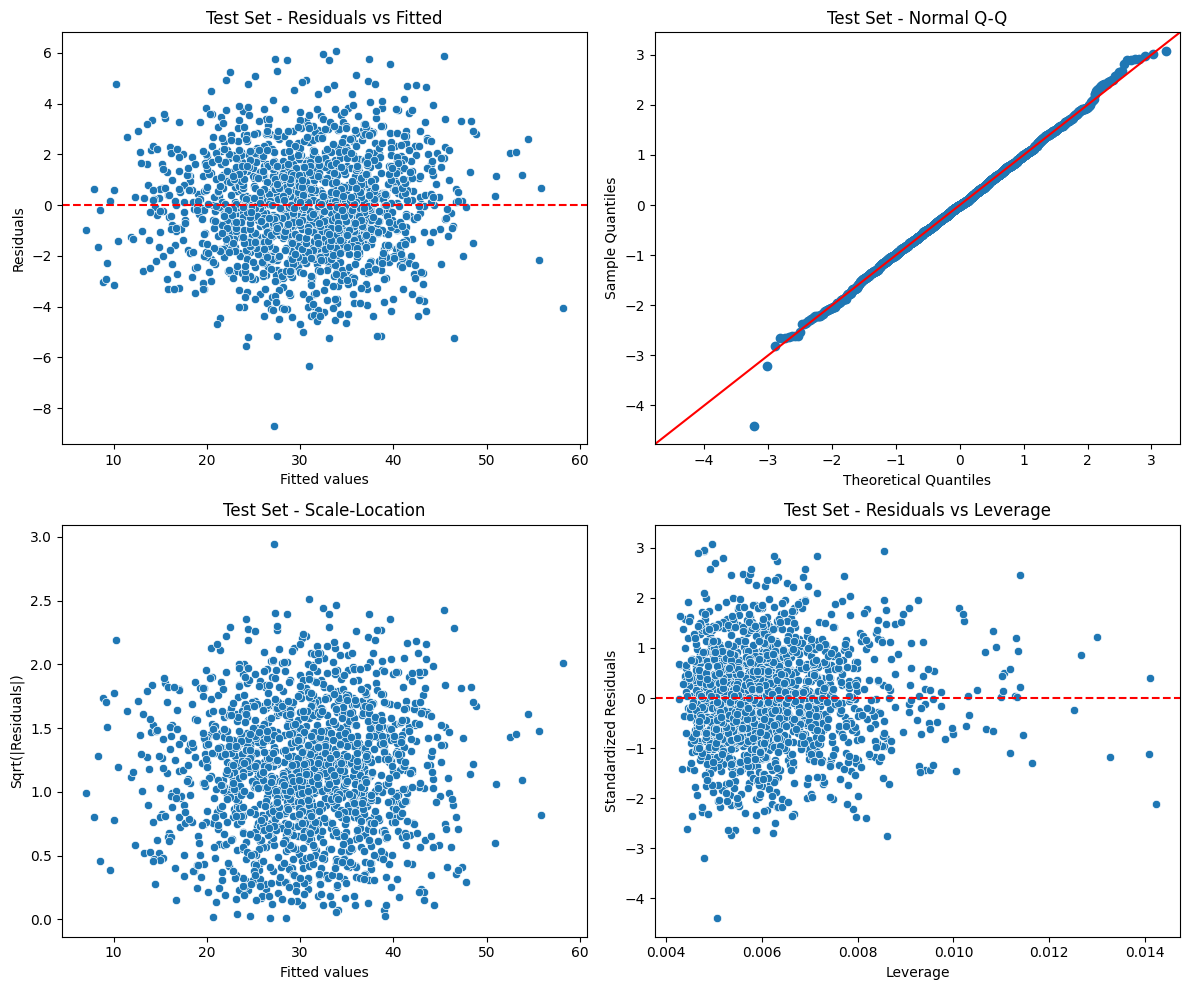

In [109]:
# Residuals vs Fitted checks for non-linearity
# Normal Q-Q checks normality of residuals
# Scale-Location checks homoscedasticity
# Residuals vs Leverage identifies influential points

regression_diagnostics(best_model_pipeline, X_train_full, y_train_full, "Training Set")
regression_diagnostics(best_model_pipeline, X_test, y_test, "Test Set")

In [113]:
def plot_profiles(best_pipeline, X, y_true):
    y_pred = best_pipeline.predict(X)
    
    n_cols = 3
    n_features = X.shape[1]
    n_rows = math.ceil(n_features / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  

    for i, col in enumerate(X.columns):
        df = pd.DataFrame({
            col: X[col],
            "y_true": y_true,
            "y_pred": y_pred
        })

        grouped = df.groupby(col).agg(
            count=("y_true", "size"),
            avg_true=("y_true", "mean"),
            avg_pred=("y_pred", "mean")
        ).reset_index().sort_values(col)

        ax1 = axes[i]
        ax1.bar(grouped[col], grouped["count"], alpha=0.3)
        ax1.set_xlabel(col)
        ax1.set_ylabel("Population")

        ax2 = ax1.twinx()
        ax2.plot(grouped[col], grouped["avg_true"], marker="o", label="Actual Target")
        ax2.plot(grouped[col], grouped["avg_pred"], marker="o", linestyle="--", label="Predicted Target")
        ax2.set_ylabel("Target Value")

        ax1.set_title(col)
        ax2.legend(loc="upper right")


    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

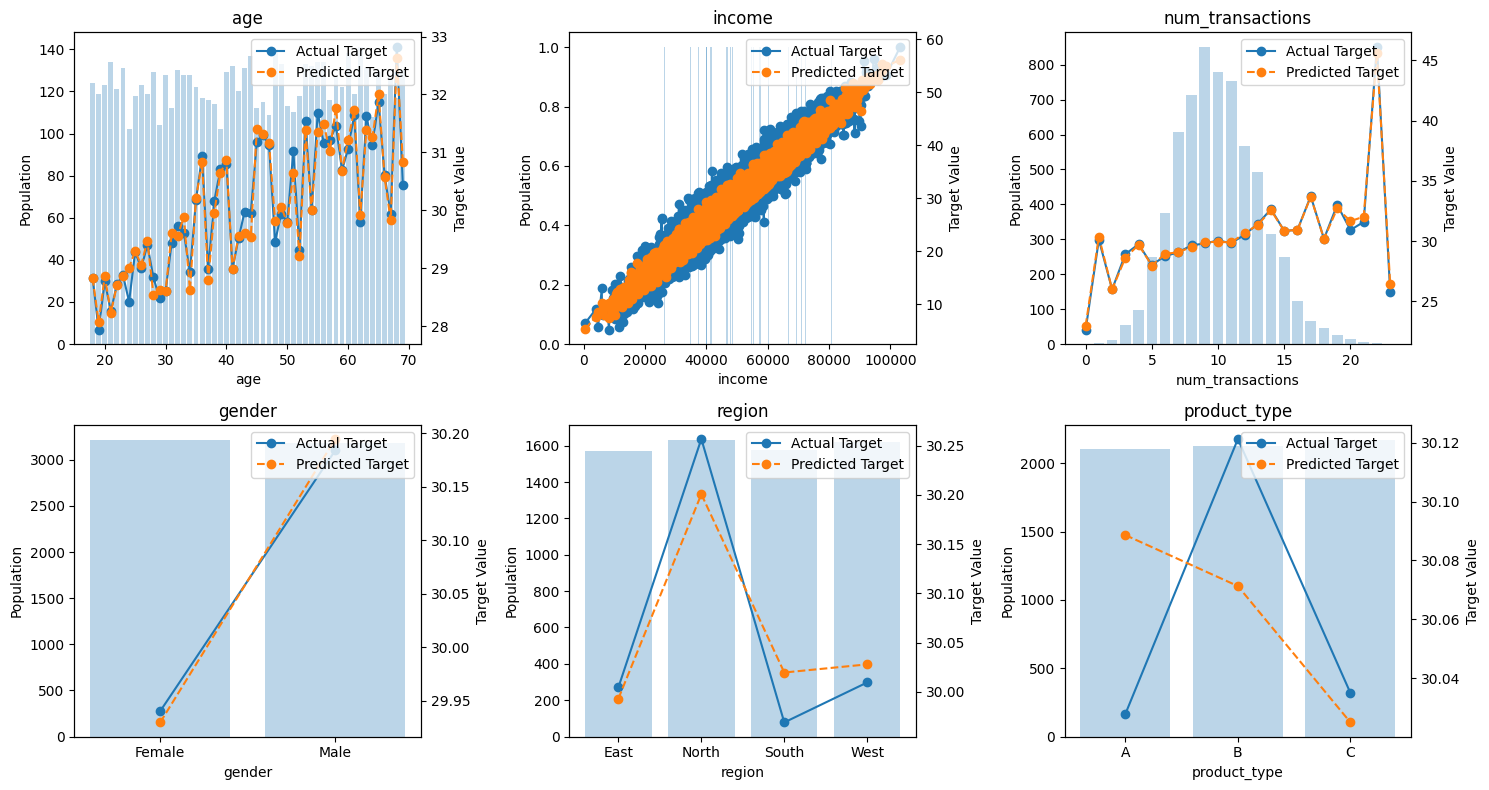

In [114]:
plot_profiles(best_model_pipeline, X_train_full, y_train_full)

In [ ]:
# future work:
#   feature enineering, interactions, polynomial, binning (Use FunctionTransformer, PolynomialFeatures)
#   Imbalanced Classificaiton class_weight='balanced' for logistic
#   propbablity output thresholds are fixed at 0.5. Consider optimizing threshold using ROC/PR